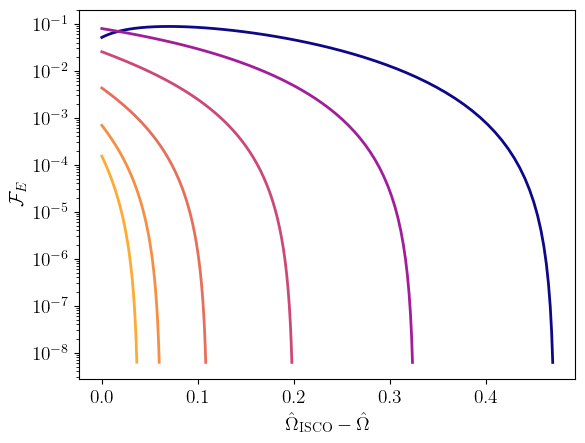

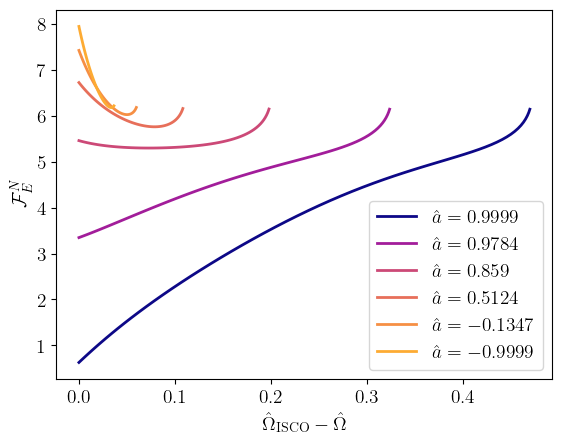

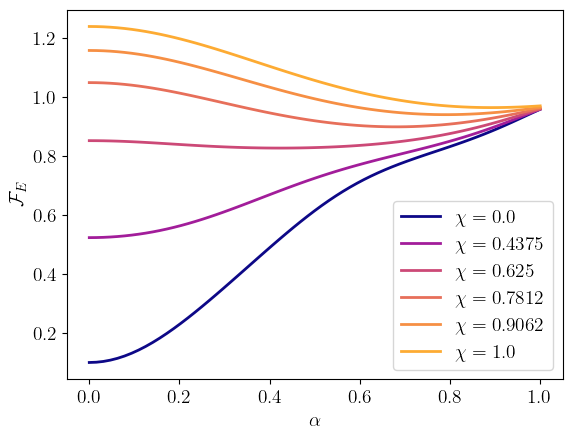

In [152]:
from bhpwave.spline import CubicSpline, BicubicSpline
from bhpwave.trajectory.geodesic import kerr_isco_frequency, kerr_circ_geo_radius

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
mpl.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
mpl.rc('text', usetex=True)
mpl.rc('font', **{'size' : 14})

import os
# pathname = os.path.dirname(os.path.abspath(__file__))

OMEGA_MIN = 2.e-3
A_MAX = 0.9999

def alpha_of_a_omega(a, omega):
    oISCO = kerr_isco_frequency(a)
    return alpha_of_omega_ISCO(omega, oISCO)

def alpha_of_omega_ISCO(omega, oISCO):
    return (abs(oISCO**(1./3.) - omega**(1./3.))/(oISCO**(1./3.) - OMEGA_MIN**(1./3.)))**(0.5)

def omega_of_a_alpha(a, alpha):
    oISCO = kerr_isco_frequency(a)
    return omega_of_alpha_ISCO(alpha, oISCO)

def omega_of_alpha_ISCO(alpha, oISCO):
    return pow(pow(oISCO, 1./3.) - pow(alpha, 2.)*(pow(oISCO, 1./3.) - pow(OMEGA_MIN, 1./3.)), 3.)

def chi_of_spin_subfunc(a):
    return pow(1. - a, 1./3.)

def chi_of_spin(a):
    return pow((chi_of_spin_subfunc(a) - chi_of_spin_subfunc(A_MAX))/(chi_of_spin_subfunc(-A_MAX) - chi_of_spin_subfunc(A_MAX)), 0.5)

def spin_of_chi(chi):
    return 1. - pow(chi_of_spin_subfunc(A_MAX) + pow(chi, 2.)*(chi_of_spin_subfunc(-A_MAX) - chi_of_spin_subfunc(A_MAX)), 3.)

def a_omega_to_chi_alpha(a, omega):
    chi = chi_of_spin(a)
    alpha = alpha_of_a_omega(a, omega)
    return (chi, alpha)

traj = np.loadtxt("../data/trajectory.txt", skiprows=3)
trajHeader = np.loadtxt("../data/trajectory.txt", skiprows=2, max_rows=1, dtype='str')
trajShape = np.loadtxt("../data/trajectory.txt", skiprows=1, max_rows=1, dtype='int')

phaseData = np.ascontiguousarray(traj[:, 4].reshape(trajShape))
timeData = np.ascontiguousarray(traj[:, 3].reshape(trajShape))
fluxData = np.ascontiguousarray(traj[:, 2].reshape(trajShape))
chiData = np.ascontiguousarray(traj[:, 0].reshape(trajShape)[:, 0])
alphaData = np.ascontiguousarray(traj[:, 1].reshape(trajShape)[0])

Edot = BicubicSpline(chiData, alphaData, fluxData, bc = "E(3)")
PhiCheck = BicubicSpline(chiData, alphaData, phaseData, bc = "E(3)")
TCheck = BicubicSpline(chiData, alphaData, timeData, bc = "E(3)")

downsample_rate = 4
Nb = int((chiData.shape[0] - 1)/downsample_rate + 1)
Na = int((alphaData.shape[0] - 1)/downsample_rate + 1)
flux_samples = np.zeros((Nb, Na, 5))
phase_samples = np.zeros((Nb, Na, 5))
time_samples = np.zeros((Nb, Na, 5))
for i in range(Nb):
    for j in range(Na):
        chi = chiData[downsample_rate*i]
        alpha = alphaData[downsample_rate*j]
        atemp = spin_of_chi(chi)
        otemp = omega_of_a_alpha(atemp, alpha)
        EdotData = Edot(chi, alpha)
        PData = PhiCheck(chi, alpha)
        TData = TCheck(chi, alpha)
        flux_samples[i, j] = [atemp, otemp, EdotData, alpha, chi]
        phase_samples[i, j] = [atemp, otemp, PData, alpha, chi]
        time_samples[i, j] = [atemp, otemp, TData, alpha, chi]

cmap_temp = mpl.colormaps['plasma'].resampled(80)
alist = [0, 14, 20, 25, 29, 32]

for i in alist: 
    avals, omegas, EdotVals = flux_samples[i,:,:3].T
    EdotVals_reweighted = 32./5.*EdotVals*omegas**(10/3)
    plt.plot(omegas[0] - omegas, EdotVals_reweighted, label="$\hat{a}" + "= {:.4}$".format(avals[0]), color=cmap_temp(2*i), lw=2)
# plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\hat{\Omega}_\mathrm{ISCO} - \hat{\Omega}$')
plt.ylabel('$\mathcal{F}_E$')
# plt.legend()
plt.show()

for i in alist: 
    avals, omegas, EdotVals = flux_samples[i,:,:3].T
    EdotVals_reweighted = 32./5.*EdotVals
    plt.plot(omegas[0] - omegas, EdotVals_reweighted, label="$\hat{a}" + "= {:.4}$".format(avals[0]), color=cmap_temp(2*i), lw=2)
# plt.xscale('log')
# plt.yscale('log')
plt.xlabel('$\hat{\Omega}_\mathrm{ISCO} - \hat{\Omega}$')
plt.ylabel('$\mathcal{F}_E^N$')
plt.legend()
plt.show()

for i in alist: 
    avals, omegas, EdotVals = flux_samples[i,:,:3].T
    alphas, chis = flux_samples[i,:,3:].T
    plt.plot(alphas, EdotVals, label="$\\chi = {:.4}$".format(chis[0]), color=cmap_temp(2*i), lw=2)
# plt.xscale('log')
# plt.yscale('log')
plt.xlabel('$\\alpha$')
plt.ylabel('$\mathcal{F}_E$')
plt.legend()
plt.show()

# for i in [0, 10, 14, 22, 26, 30, 32]: 
#     avals, omegas, EdotVals = flux_samples[i].T
#     EdotVals_reweighted = 32./5.*EdotVals*omegas**(10/3)
#     plt.plot(omegas, EdotVals_reweighted, label="$a = {:.4}$".format(avals[0]), color=cmap_temp(2*i), lw=2)
# plt.xscale('log')
# plt.yscale('log')
# plt.xlabel('$\hat{\Omega}$')
# plt.ylabel('$\mathcal{F}_E$')
# plt.legend()
# plt.savefig(pathname+"/../figures/trajectory_a_omega.pdf", bbox_inches="tight", dpi=300)

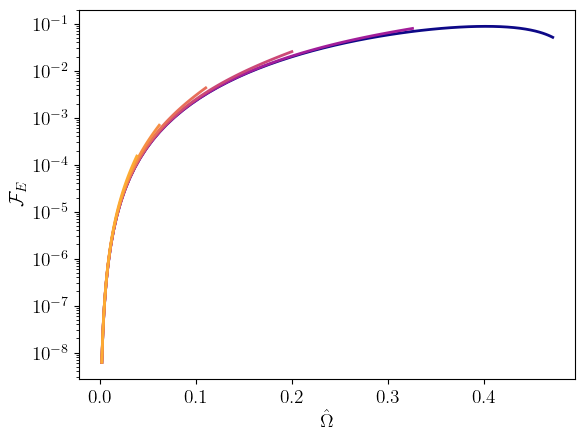

In [153]:
for i in alist: 
    avals, omegas, EdotVals = flux_samples[i,:,:3].T
    EdotVals_reweighted = 32./5.*EdotVals*omegas**(10/3)
    plt.plot(omegas, EdotVals_reweighted, label="$\hat{a}" + "= {:.4}$".format(avals[0]), color=cmap_temp(2*i), lw=2)
# plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\hat{\Omega}$')
plt.ylabel('$\mathcal{F}_E$')
# plt.legend()
plt.show()

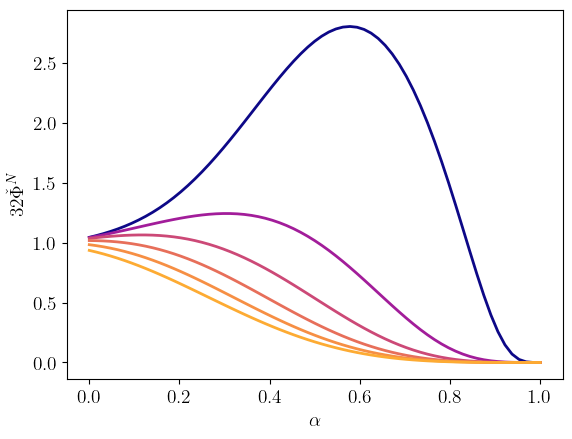

In [154]:
for i in alist: 
    avals, omegas, PVals = phase_samples[i,:,:3].T
    Pvals_shifted = 32*(PVals)*omegas**(5/3)
    alphas, chis = flux_samples[i,:,3:].T
    plt.plot(alphas, np.flip(Pvals_shifted), label="$a = {:.4}$".format(avals[0]), color=cmap_temp(2*i), lw=2)
    avals, omegas, TVals = time_samples[i,:,:3].T
    Tvals_shifted = 256/5*TVals*(omegas)**(8/3)
    # plt.plot(alphas, np.flip(Tvals_shifted), '--', color=cmap_temp(2*i), lw=2)
# plt.xscale('log')
# plt.yscale('log')
plt.xlabel('$\\alpha$')
plt.ylabel('$32\check{\Phi}^N$')
# plt.legend()
plt.show()

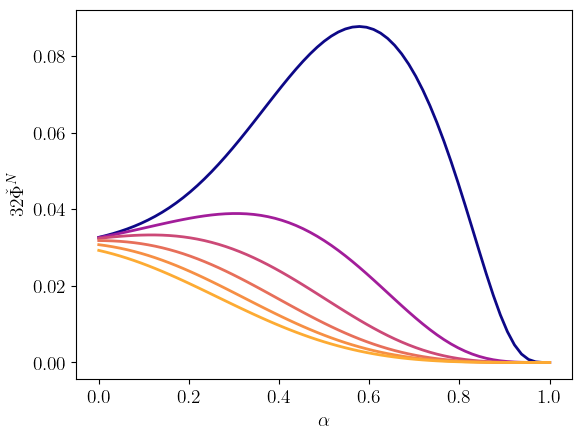

In [155]:
for i in alist: 
    avals, omegas, PVals = phase_samples[i,:,:3].T
    alphas, chis = flux_samples[i,:,3:].T
    Pvals_shifted = PVals*omegas**(5/3)
    plt.plot(alphas, np.flip(Pvals_shifted), label="$a = {:.4}$".format(avals[0]), color=cmap_temp(2*i), lw=2)
# plt.xscale('log')
# plt.yscale('log')
plt.xlabel('$\\alpha$')
plt.ylabel('$32\check{\Phi}^N$')
# plt.legend()
plt.show()

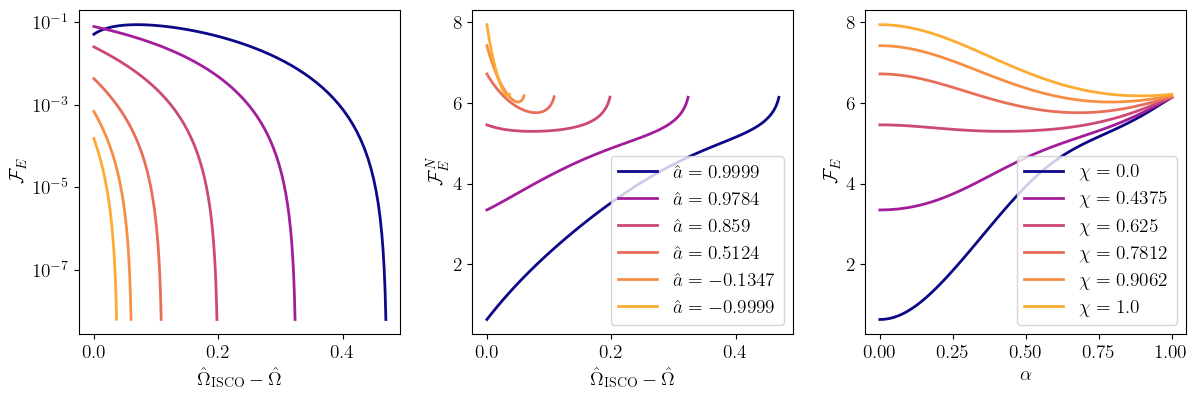

In [156]:
fig, axs = plt.subplots(1, 3,)
fig.set_size_inches(12, 4)
fig.tight_layout()
for i in alist: 
    avals, omegas, EdotVals = flux_samples[i,:,:3].T
    EdotVals_reweighted = 32./5.*EdotVals*omegas**(10/3)
    axs[0].plot(omegas[0] - omegas, EdotVals_reweighted, label="$\hat{a}" + "= {:.4}$".format(avals[0]), color=cmap_temp(2*i), lw=2)
# plt.xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlabel('$\hat{\Omega}_\mathrm{ISCO} - \hat{\Omega}$')
axs[0].set_ylabel('$\mathcal{F}_E$')

for i in alist: 
    avals, omegas, EdotVals = flux_samples[i,:,:3].T
    EdotVals_reweighted = 32./5.*EdotVals
    axs[1].plot(omegas[0] - omegas, EdotVals_reweighted, label="$\hat{a}" + "= {:.4}$".format(avals[0]), color=cmap_temp(2*i), lw=2)
axs[1].set_xlabel('$\hat{\Omega}_\mathrm{ISCO} - \hat{\Omega}$')
axs[1].set_ylabel('$\mathcal{F}_E^N$')
axs[1].legend()

for i in alist: 
    avals, omegas, EdotVals = flux_samples[i,:,:3].T
    alphas, chis = flux_samples[i,:,3:].T
    axs[2].plot(alphas, 32./5.*EdotVals, label="$\\chi = {:.4}$".format(chis[0]), color=cmap_temp(2*i), lw=2)
axs[2].set_xlabel('$\\alpha$')
axs[2].set_ylabel('$\mathcal{F}_E$')
axs[2].legend()
plt.show()

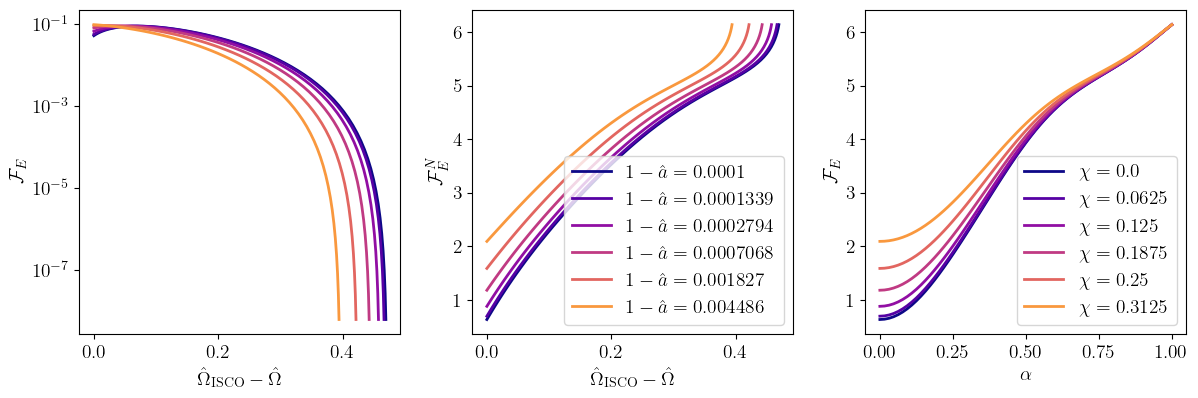

In [157]:
alistHighSpin = [0, 2, 4, 6, 8, 10]
fig, axs = plt.subplots(1, 3,)
fig.set_size_inches(12, 4)
fig.tight_layout()
for i in alistHighSpin: 
    avals, omegas, EdotVals = flux_samples[i,:,:3].T
    EdotVals_reweighted = 32./5.*EdotVals*omegas**(10/3)
    axs[0].plot(omegas[0] - omegas, EdotVals_reweighted, label="$1-\hat{a}" + "= {:.4}$".format(1-avals[0]), color=cmap_temp(6*i), lw=2)
# plt.xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlabel('$\hat{\Omega}_\mathrm{ISCO} - \hat{\Omega}$')
axs[0].set_ylabel('$\mathcal{F}_E$')

for i in alistHighSpin: 
    avals, omegas, EdotVals = flux_samples[i,:,:3].T
    EdotVals_reweighted = 32./5.*EdotVals
    axs[1].plot(omegas[0] - omegas, EdotVals_reweighted, label="$1-\hat{a}" + "= {:.4}$".format(1-avals[0]), color=cmap_temp(6*i), lw=2)
axs[1].set_xlabel('$\hat{\Omega}_\mathrm{ISCO} - \hat{\Omega}$')
axs[1].set_ylabel('$\mathcal{F}_E^N$')
axs[1].legend()

for i in alistHighSpin: 
    avals, omegas, EdotVals = flux_samples[i,:,:3].T
    alphas, chis = flux_samples[i,:,3:].T
    axs[2].plot(alphas, 32./5.*EdotVals, label="$\\chi = {:.4}$".format(chis[0]), color=cmap_temp(6*i), lw=2)
axs[2].set_xlabel('$\\alpha$')
axs[2].set_ylabel('$\mathcal{F}_E$')
axs[2].legend()
plt.show()

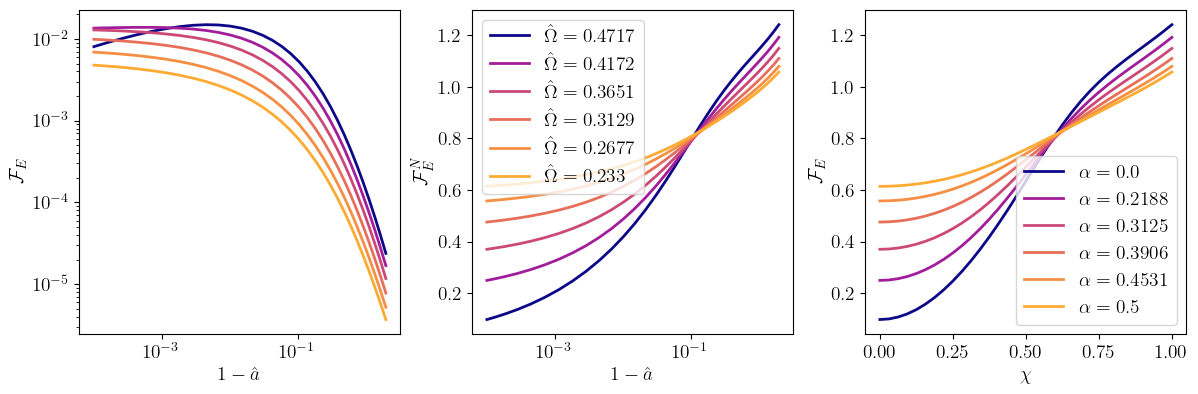

In [158]:
olist = [0, 14, 20, 25, 29, 32]
fig, axs = plt.subplots(1, 3,)
fig.set_size_inches(12, 4)
fig.tight_layout()
for i in olist: 
    avals, omegas, EdotVals = flux_samples[:,i,:3].T
    EdotVals_reweighted = EdotVals*omegas**(10/3)
    axs[0].plot(1-avals, EdotVals_reweighted, label="$1-\hat{a}" + "= {:.4}$".format(omegas[0]), color=cmap_temp(2*i), lw=2)
# plt.xscale('log')
axs[0].set_yscale('log')
axs[0].set_xscale('log')
axs[0].set_xlabel('$1 - \hat{a}$')
axs[0].set_ylabel('$\mathcal{F}_E$')

for i in olist: 
    avals, omegas, EdotVals = flux_samples[:,i,:3].T
    EdotVals_reweighted = EdotVals
    axs[1].plot(1 - avals, EdotVals_reweighted, label="$\hat{\Omega}" + "= {:.4}$".format(omegas[0]), color=cmap_temp(2*i), lw=2)
axs[1].set_xscale('log')
axs[1].set_xlabel('$1 - \hat{a}$')
axs[1].set_ylabel('$\mathcal{F}_E^N$')
axs[1].legend()

for i in olist: 
    avals, omegas, EdotVals = flux_samples[:,i,:3].T
    alphas, chis = flux_samples[:,i,3:].T
    axs[2].plot(chis, EdotVals, label="$\\alpha = {:.4}$".format(alphas[0]), color=cmap_temp(2*i), lw=2)
axs[2].set_xlabel('$\\chi$')
axs[2].set_ylabel('$\mathcal{F}_E$')
axs[2].legend()
plt.show()

# Check accuracy of splines

In [159]:
# from scipy.interpolate import interp2d

# EdotDataComp=np.load("/Users/znasipak/Documents/Projects/EccentricFluxes/data/bhpwave_edot_redo.npy")
# alphaa, aa = np.meshgrid(alphaData, spin_of_chi(chiData))
# omegaa = omega_of_a_alpha(aa, alphaa)
# fluxData = 2.*EdotDataComp/(32./5.*omegaa**(10./3.))

# Edot_78 = BicubicSpline(chiData, alphaData, fluxData)
# PhiCheck_78 = BicubicSpline(chiData, alphaData, phaseData)
# TCheck_78 = BicubicSpline(chiData, alphaData, timeData)

# Edot_78_py = interp2d(chiData, alphaData, fluxData.T, kind="cubic")
# PhiCheck_78_py = interp2d(chiData, alphaData, phaseData.T, kind="cubic")
# TCheck_78_py = interp2d(chiData, alphaData, timeData.T, kind="cubic")

# downsample_rate_alpha=2
# downsample_rate_chi=1
# Edot_77 = BicubicSpline((chiData[::downsample_rate_chi]), (alphaData[::downsample_rate_alpha]), (fluxData[::downsample_rate_chi,::downsample_rate_alpha]))
# PhiCheck_77 = BicubicSpline((chiData[::downsample_rate_chi]), (alphaData[::downsample_rate_alpha]), (phaseData[::downsample_rate_chi,::downsample_rate_alpha]))
# TCheck_77 = BicubicSpline((chiData[::downsample_rate_chi]), (alphaData[::downsample_rate_alpha]), (timeData[::downsample_rate_chi,::downsample_rate_alpha]))

# Edot_77_py = interp2d(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(fluxData[::downsample_rate_chi,::downsample_rate_alpha]).T, kind="cubic")
# PhiCheck_77_py = interp2d(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(phaseData[::downsample_rate_chi,::downsample_rate_alpha]).T, kind="cubic")
# TCheck_77_py = interp2d(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(timeData[::downsample_rate_chi,::downsample_rate_alpha]).T, kind="cubic")

# downsample_rate_alpha=4
# downsample_rate_chi=1
# Edot_76 = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(fluxData[::downsample_rate_chi,::downsample_rate_alpha]))
# PhiCheck_76 = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(phaseData[::downsample_rate_chi,::downsample_rate_alpha]))
# TCheck_76 = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(timeData[::downsample_rate_chi,::downsample_rate_alpha]))

# downsample_rate_alpha=8
# downsample_rate_chi=1
# Edot_75 = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(fluxData[::downsample_rate_chi,::downsample_rate_alpha]))
# PhiCheck_75 = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(phaseData[::downsample_rate_chi,::downsample_rate_alpha]))
# TCheck_75 = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(timeData[::downsample_rate_chi,::downsample_rate_alpha]))

# downsample_rate_alpha=1
# downsample_rate_chi=2
# Edot_68 = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(fluxData[::downsample_rate_chi,::downsample_rate_alpha]))
# PhiCheck_68 = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(phaseData[::downsample_rate_chi,::downsample_rate_alpha]))
# TCheck_68 = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(timeData[::downsample_rate_chi,::downsample_rate_alpha]))

# downsample_rate_alpha=1
# downsample_rate_chi=4
# Edot_58 = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(fluxData[::downsample_rate_chi,::downsample_rate_alpha]))
# PhiCheck_58 = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(phaseData[::downsample_rate_chi,::downsample_rate_alpha]))
# TCheck_58 = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(timeData[::downsample_rate_chi,::downsample_rate_alpha]))

# downsample_rate_alpha=1
# downsample_rate_chi=8
# Edot_48 = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(fluxData[::downsample_rate_chi,::downsample_rate_alpha]))
# PhiCheck_48 = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(phaseData[::downsample_rate_chi,::downsample_rate_alpha]))
# TCheck_48 = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(timeData[::downsample_rate_chi,::downsample_rate_alpha]))

# downsample_rate_alpha=2
# downsample_rate_chi=2
# Edot_67 = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(fluxData[::downsample_rate_chi,::downsample_rate_alpha]))
# PhiCheck_67 = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(phaseData[::downsample_rate_chi,::downsample_rate_alpha]))
# TCheck_67 = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(timeData[::downsample_rate_chi,::downsample_rate_alpha]))

# downsample_rate_alpha=4
# downsample_rate_chi=4
# Edot_56 = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(fluxData[::downsample_rate_chi,::downsample_rate_alpha]))
# PhiCheck_56 = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(phaseData[::downsample_rate_chi,::downsample_rate_alpha]))
# TCheck_56 = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(timeData[::downsample_rate_chi,::downsample_rate_alpha]))

# downsample_rate_alpha=8
# downsample_rate_chi=8
# Edot_45 = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(fluxData[::downsample_rate_chi,::downsample_rate_alpha]))
# PhiCheck_45 = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(phaseData[::downsample_rate_chi,::downsample_rate_alpha]))
# TCheck_45 = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(timeData[::downsample_rate_chi,::downsample_rate_alpha]))

In [166]:
from scipy.interpolate import interp2d

EdotDataComp=np.load("/Users/znasipak/Documents/Projects/EccentricFluxes/data/bhpwave_edot_redo.npy")
alphaa, aa = np.meshgrid(alphaData, spin_of_chi(chiData))
omegaa = omega_of_a_alpha(aa, alphaa)
fluxData = 2.*EdotDataComp/(32./5.*omegaa**(10./3.))

Edot_78 = BicubicSpline(chiData, alphaData, fluxData, bc = "E(3)")
PhiCheck_78 = BicubicSpline(chiData, alphaData, phaseData, bc = "E(3)")
TCheck_78 = BicubicSpline(chiData, alphaData, timeData, bc = "E(3)")

downsample_rate_alpha=2
downsample_rate_chi=2
Edot_67 = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(fluxData[::downsample_rate_chi,::downsample_rate_alpha]))
PhiCheck_67 = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(phaseData[::downsample_rate_chi,::downsample_rate_alpha]))
TCheck_67 = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(timeData[::downsample_rate_chi,::downsample_rate_alpha]))

downsample_rate_alpha=4
downsample_rate_chi=4
Edot_56 = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(fluxData[::downsample_rate_chi,::downsample_rate_alpha]))
PhiCheck_56 = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(phaseData[::downsample_rate_chi,::downsample_rate_alpha]))
TCheck_56 = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(timeData[::downsample_rate_chi,::downsample_rate_alpha]))

downsample_rate_alpha=16
downsample_rate_chi=16
Edot_34 = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(fluxData[::downsample_rate_chi,::downsample_rate_alpha]))
PhiCheck_34 = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(phaseData[::downsample_rate_chi,::downsample_rate_alpha]))
TCheck_34 = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(timeData[::downsample_rate_chi,::downsample_rate_alpha]))

downsample_rate_alpha=8
downsample_rate_chi=8
Edot_45 = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(fluxData[::downsample_rate_chi,::downsample_rate_alpha]))
PhiCheck_45 = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(phaseData[::downsample_rate_chi,::downsample_rate_alpha]))
TCheck_45 = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(timeData[::downsample_rate_chi,::downsample_rate_alpha]))

bc = 'not-a-knot'

Edot_78_nok = BicubicSpline(chiData, alphaData, fluxData, bc=bc)
PhiCheck_78_nok = BicubicSpline(chiData, alphaData, phaseData, bc=bc)
TCheck_78_nok = BicubicSpline(chiData, alphaData, timeData, bc=bc)

downsample_rate_alpha=2
downsample_rate_chi=2
Edot_67_nok = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(fluxData[::downsample_rate_chi,::downsample_rate_alpha]), bc=bc)
PhiCheck_67_nok = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(phaseData[::downsample_rate_chi,::downsample_rate_alpha]), bc=bc)
TCheck_67_nok = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(timeData[::downsample_rate_chi,::downsample_rate_alpha]), bc=bc)

downsample_rate_alpha=4
downsample_rate_chi=4
Edot_56_nok = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(fluxData[::downsample_rate_chi,::downsample_rate_alpha]), bc=bc)
PhiCheck_56_nok = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(phaseData[::downsample_rate_chi,::downsample_rate_alpha]), bc=bc)
TCheck_56_nok = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(timeData[::downsample_rate_chi,::downsample_rate_alpha]), bc=bc)

downsample_rate_alpha=8
downsample_rate_chi=8
Edot_45_nok = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(fluxData[::downsample_rate_chi,::downsample_rate_alpha]), bc=bc)
PhiCheck_45_nok = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(phaseData[::downsample_rate_chi,::downsample_rate_alpha]), bc=bc)
TCheck_45_nok = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(timeData[::downsample_rate_chi,::downsample_rate_alpha]), bc=bc)

bc = 'natural'

Edot_78_nat = BicubicSpline(chiData, alphaData, fluxData, bc=bc)
PhiCheck_78_nat = BicubicSpline(chiData, alphaData, phaseData, bc=bc)
TCheck_78_nat = BicubicSpline(chiData, alphaData, timeData, bc=bc)

downsample_rate_alpha=2
downsample_rate_chi=2
Edot_67_nat = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(fluxData[::downsample_rate_chi,::downsample_rate_alpha]), bc=bc)
PhiCheck_67_nat = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(phaseData[::downsample_rate_chi,::downsample_rate_alpha]), bc=bc)
TCheck_67_nat = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(timeData[::downsample_rate_chi,::downsample_rate_alpha]), bc=bc)

downsample_rate_alpha=4
downsample_rate_chi=4
Edot_56_nat = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(fluxData[::downsample_rate_chi,::downsample_rate_alpha]), bc=bc)
PhiCheck_56_nat = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(phaseData[::downsample_rate_chi,::downsample_rate_alpha]), bc=bc)
TCheck_56_nat = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(timeData[::downsample_rate_chi,::downsample_rate_alpha]), bc=bc)

downsample_rate_alpha=8
downsample_rate_chi=8
Edot_45_nat = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(fluxData[::downsample_rate_chi,::downsample_rate_alpha]), bc=bc)
PhiCheck_45_nat = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(phaseData[::downsample_rate_chi,::downsample_rate_alpha]), bc=bc)
TCheck_45_nat = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(timeData[::downsample_rate_chi,::downsample_rate_alpha]), bc=bc)

In [167]:
alphaJs = np.linspace(0., 1., 502)
chiIs = np.linspace(0., 1., 502)
error_test=np.array([[abs(1-Edot_67(chiI, alphaJ)/Edot_78(chiI, alphaJ)) for chiI in chiIs] for alphaJ in alphaJs])
error_test[error_test==0.]=1.e-16
error_test_2=np.array([[abs(1-Edot_56(chiI, alphaJ)/Edot_78(chiI, alphaJ)) for chiI in chiIs] for alphaJ in alphaJs])
error_test_2[error_test_2==0.]=1.e-16
error_test_3=np.array([[abs(1-Edot_45(chiI, alphaJ)/Edot_78(chiI, alphaJ)) for chiI in chiIs] for alphaJ in alphaJs])
error_test_3[error_test_3==0.]=1.e-16
error_test_4=np.array([[abs(1-Edot_34(chiI, alphaJ)/Edot_78(chiI, alphaJ)) for chiI in chiIs] for alphaJ in alphaJs])
error_test_4[error_test_4==0.]=1.e-16
np.max(error_test_2)/np.max(error_test), np.max(error_test_3)/np.max(error_test_2)

(16.2392119235935, 15.812238411090451)

In [176]:
np.flip(np.arange(3,7))

array([6, 5, 4, 3])

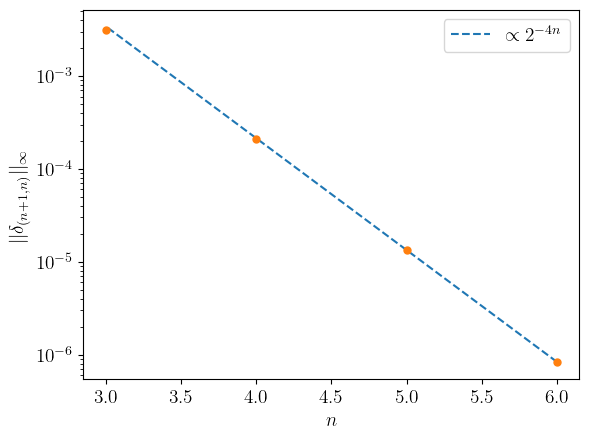

In [191]:
plt.plot([6, 5, 4, 3], [np.max(error_test_2)*16**(5-n) for n in [6, 5, 4, 3]], '--', label = "$\propto 2^{-4n}$")
plt.plot([6, 5, 4, 3], [np.max(error_test), np.max(error_test_2), np.max(error_test_3), np.max(error_test_4)], '.', markersize=10)
plt.yscale('log')
plt.ylabel('$||\delta_{(n+1,n)}||_\infty$')
plt.xlabel('$n$')
plt.legend()
plt.show()

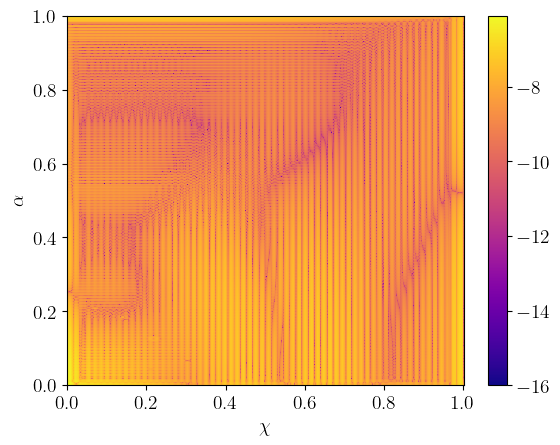

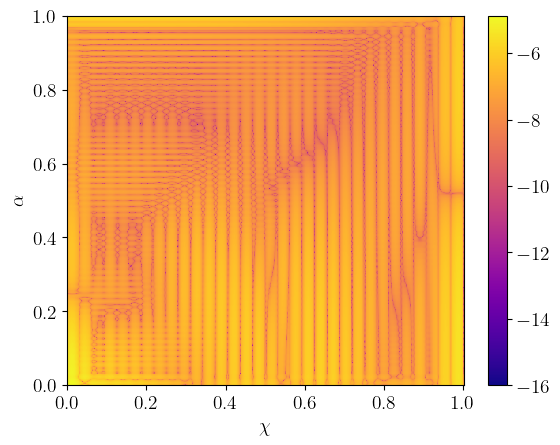

In [162]:
plt.pcolormesh(chiIs, alphaJs, np.log10(error_test), cmap='plasma', shading='auto')
plt.ylabel('$\\alpha$')
plt.xlabel('$\\chi$')
plt.colorbar()
plt.show()
plt.pcolormesh(chiIs, alphaJs, np.log10(error_test_2), cmap='plasma', shading='auto')
plt.ylabel('$\\alpha$')
plt.xlabel('$\\chi$')
plt.colorbar()
plt.show()

# Compare with Toolkit data

In [16]:
from bhpwave.spline import CubicSpline, BicubicSpline
from bhpwave.trajectory.geodesic import kerr_isco_frequency, kerr_circ_geo_radius, kerr_circ_geo_orbital_frequency, kerr_isco_radius

In [17]:
import os 
bhptoolkit_file_location = "https://raw.githubusercontent.com/BlackHolePerturbationToolkit/CircularOrbitSelfForceData/master/Kerr/Fluxes/Flux_Edot_a"
aval_strings = ["-0.99", "-0.8", "-0.5", "0.1", "0.6", "0.9", "0.995", "0.999"]
for aval in aval_strings:
    file_check = "Flux_Edot_a" + aval + ".dat"
    wget_string = "wget " + bhptoolkit_file_location + aval + ".dat"
    print(file_check)
    if not os.path.isfile(file_check):
        os.system(wget_string)

Flux_Edot_a-0.99.dat
Flux_Edot_a-0.8.dat
Flux_Edot_a-0.5.dat
Flux_Edot_a0.1.dat
Flux_Edot_a0.6.dat
Flux_Edot_a0.9.dat
Flux_Edot_a0.995.dat
Flux_Edot_a0.999.dat


In [92]:
EdotDataComp=np.load("/Users/znasipak/Documents/Projects/EccentricFluxes/data/bhpwave_edot_redo.npy")
alphaa, aa = np.meshgrid(alphaData, spin_of_chi(chiData))
omegaa = omega_of_a_alpha(aa, alphaa)
spl=BicubicSpline(np.linspace(0, 1, 129), np.linspace(0, 1, 257), 2.*EdotDataComp/(32./5.*omegaa**(10./3.)), bc="E(3)")
spl2=BicubicSpline(np.linspace(0, 1, 129), np.linspace(0, 1, 257), 2.*EdotDataComp/(32./5.*omegaa**(10./3.)), bc="natural")
spl3=BicubicSpline(np.linspace(0, 1, 129), np.linspace(0, 1, 257), 2.*EdotDataComp/(32./5.*omegaa**(10./3.)), bc="not-a-knot")
def scaled_energy_flux(a, r0, bc="E(3)"):
    omega = kerr_circ_geo_orbital_frequency(a, r0)
    alpha = alpha_of_a_omega(a, omega)
    chi = chi_of_spin(a)
    if bc == "E(3)":
        return spl(chi, alpha)*32./5.*omega**(10./3.)
    elif bc == "natural":
        return spl2(chi, alpha)*32./5.*omega**(10./3.)
    elif bc == "not-a-knot":
        return spl3(chi, alpha)*32./5.*omega**(10./3.)
    else:
        return spl(chi, alpha)*32./5.*omega**(10./3.)

In [93]:
flux_file_list = ["Flux_Edot_a0.999.dat", 
                  "Flux_Edot_a0.995.dat", 
                  "Flux_Edot_a0.9.dat", 
                  "Flux_Edot_a0.6.dat", 
                  "Flux_Edot_a0.1.dat", 
                  "Flux_Edot_a-0.5.dat",
                  "Flux_Edot_a-0.8.dat",
                  "Flux_Edot_a-0.99.dat"]
flux_spin_list = [0.999, 0.995, 0.9, 0.6, 0.1, -0.5, -0.8, -0.99]

In [94]:
testData = []
for file, spin in zip(flux_file_list, flux_spin_list):
    tempData = np.loadtxt(file)
    tempData = tempData[tempData[:,0] < 62.]
    testData.append([spin, tempData])

In [117]:
comparisons = []
comparisons2 = []
bc = 'E(3)'
for data in testData:
    a = data[0]
    compData = data[1]
    r_vals = compData[:, 0]
    flux_vals = compData[:, 1] + compData[:, 2]
    flux_comparison = np.zeros((r_vals.shape[0]))
    for i in range(flux_comparison.shape[0]):
        flux_comparison[i] = scaled_energy_flux(a, r_vals[i], bc=bc)
    comparisons.append([r_vals, np.abs(1. - flux_comparison/flux_vals)])
    comparisons2.append([r_vals, np.abs(flux_comparison-flux_vals)])

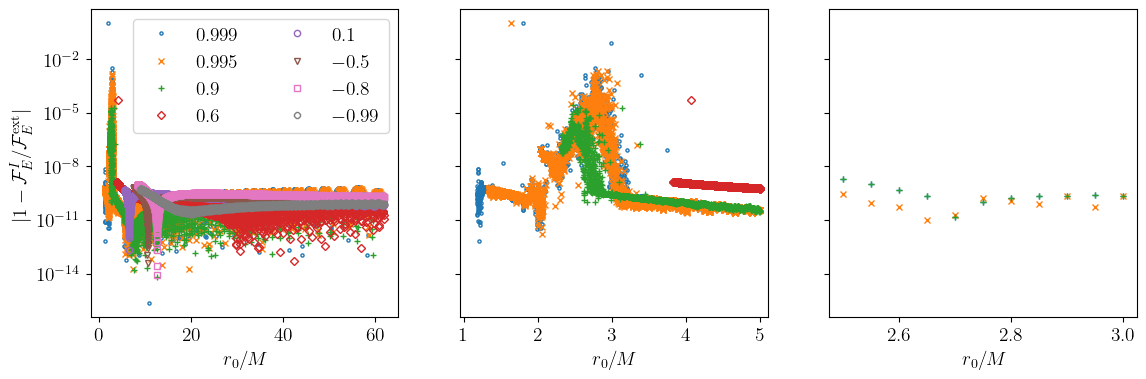

In [149]:
markers = ['.', 'x', '+', 'D', 'o', 'v', 's', '8']
fig, axs = plt.subplots(1,3, sharey=True)
fig.set_size_inches(13.5, 4.)
for i, comparison in enumerate(comparisons):
    axs[0].plot(comparison[0][::2], comparison[1][::2], markers[i], label="$"+str(flux_spin_list[i])+"$", markersize = 4.5, fillstyle='none')
axs[0].set_yscale('log')
axs[0].legend(loc="upper right", ncol=2)
axs[0].set_xlabel('$r_0/M$')
axs[0].set_ylabel('$|1 - {\mathcal{F}_E^I}/{\mathcal{F}_E^\mathrm{ext}}|$')

for i, comparison in enumerate(comparisons3):
    axs[1].plot(comparison[0], comparison[1], markers[i], label="$"+str(flux_spin_list[i])+"$", markersize = 4.5, fillstyle='none')
axs[1].set_yscale('log')
# plt.legend(loc="upper right")
axs[1].set_xlabel('$r_0/M$')
axs[1].set_xlim(0.95, 5.1)
# axs[1].set_ylabel('$|1 - {\mathcal{F}_E^I}/{\mathcal{F}_E^\mathrm{BHPT}}|$')

axs[2].plot(mma_comp_900[0], mma_comp_900[1], markers[2], label="$0.9$", markersize = 4.5)
axs[2].plot(mma_comp_995[0], mma_comp_995[1], markers[1], label="$0.995$", markersize = 4.5)
axs[2].plot(mma_comp_900[0], mma_comp_900[1], markers[2], label="$0.9$", markersize = 4.5)
# axs[2].set_xlim(0.95, 5.1)
axs[2].set_xlabel('$r_0/M$')

# for ax in fig.get_axes():
#     ax.label_outer()

plt.show()

In [97]:
testData2 = []
for file, spin in zip(flux_file_list[:4], flux_spin_list[:4]):
    tempData = np.loadtxt(file)
    tempData = tempData[tempData[:,0] < 5.]
    testData2.append([spin, tempData])

In [108]:
comparisons3 = []
bc_type= "E(3)"
for data in testData2:
    a = data[0]
    compData = data[1]
    r_vals = compData[:, 0]
    flux_vals = compData[:, 1] + compData[:, 2]
    flux_comparison = np.zeros((r_vals.shape[0]))
    for i in range(flux_comparison.shape[0]):
        flux_comparison[i] = scaled_energy_flux(a, r_vals[i], bc = bc_type)
    comparisons3.append([r_vals, np.abs(1. - flux_comparison/flux_vals)])

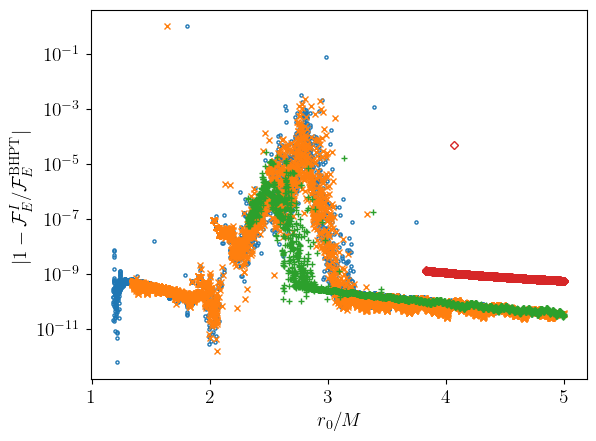

In [115]:
markers = ['.', 'x', '+', 'D', 'o', 'v', 's', '8']
for i, comparison in enumerate(comparisons3):
    plt.plot(comparison[0], comparison[1], markers[i], label="$"+str(flux_spin_list[i])+"$", markersize = 4.5, fillstyle='none')
plt.yscale('log')
# plt.legend(loc="upper right")
plt.xlabel('$r_0/M$')
plt.ylabel('$|1 - {\mathcal{F}_E^I}/{\mathcal{F}_E^\mathrm{BHPT}}|$')
plt.show()

In [110]:
mma_values_900=np.loadtxt("/Users/znasipak/Documents/Projects/CircOrbits/mathetamatica_fluxes_a9.dat")
mma_values_995=np.loadtxt("/Users/znasipak/Documents/Projects/CircOrbits/mathetamatica_fluxes_a995.dat")

In [111]:
comparison_fluxes = []
bc_type = 'not-a-knot'
for vals in mma_values_900:
    a, r0, flux, flux_error = vals
    flux_comp = scaled_energy_flux(a, r0, bc = bc_type)
    print(scaled_energy_flux(a, r0, bc = 'not-a-knot'), scaled_energy_flux(a, r0, bc = 'E(3)'), scaled_energy_flux(a, r0, bc = 'natural'))
    comparison_fluxes.append([r0, np.abs(1 - flux/flux_comp)])
mma_comp_900 = np.array(comparison_fluxes).T
comparison_fluxes = []
for vals in mma_values_995:
    a, r0, flux, flux_error = vals
    flux_comp = scaled_energy_flux(a, r0, bc = bc_type)
    comparison_fluxes.append([r0, np.abs(1 - flux/flux_comp)])
mma_comp_995 = np.array(comparison_fluxes).T

0.025994944791121546 0.025994944791121546 0.025994944791121546
0.02397398867971919 0.02397398867971919 0.02397398867971919
0.02214207915215648 0.02214207915215648 0.02214207915215648
0.020477731259969434 0.020477731259969434 0.020477731259969434
0.01896251669374157 0.01896251669374157 0.01896251669374157
0.017580508000365702 0.017580508000365702 0.017580508000365702
0.016317849458420835 0.016317849458420835 0.016317849458420835
0.015162420255691826 0.015162420255691826 0.015162420255691826
0.014103566147220194 0.014103566147220194 0.014103566147220194
0.013131882784791084 0.013131882784791084 0.013131882784791084
0.012239038657269118 0.012239038657269118 0.012239038657269118


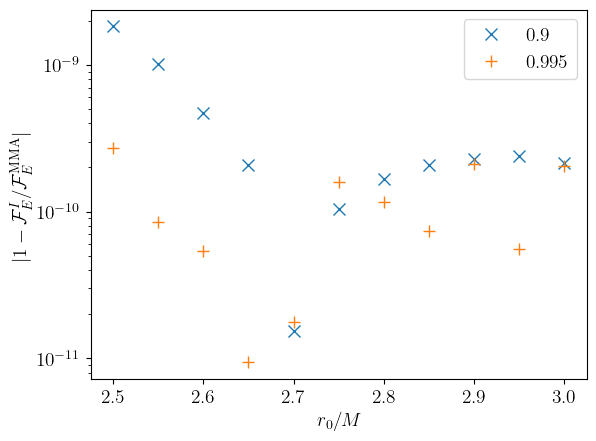

In [112]:
markers = ['.', 'x', '+', 'D', 'o', 'v', 's', '8']
# for i, comparison in enumerate(comparisons3):
#     plt.plot(comparison[0], comparison[1], markers[i], label="$"+str(flux_spin_list[i])+"$", markersize = 4.5, fillstyle='none')
plt.plot(mma_comp_900[0], mma_comp_900[1], markers[1], label="$0.9$", markersize = 8.5)
plt.plot(mma_comp_995[0], mma_comp_995[1], markers[2], label="$0.995$", markersize = 8.5)
plt.yscale('log')
plt.legend(loc="upper right")
plt.xlabel('$r_0/M$')
plt.ylabel('$|1 - {\mathcal{F}_E^I}/{\mathcal{F}_E^\mathrm{MMA}}|$')
plt.show()